# TODO

In [2]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.6 is required
import sys
assert sys.version_info >= (3, 6)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)


from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
english_train = pd.read_csv('./hateval2019/hateval2019_en_train.csv',index_col=0)
english_dev = pd.read_csv('./hateval2019/hateval2019_en_dev.csv',index_col=0)
english_test = pd.read_csv('./hateval2019/hateval2019_en_test.csv',index_col=0)

In [4]:
english_test.head()

,text,HS,TR,AG
id,,,,
34243,"@local1025 @njdotcom @GovMurphy Oh, I could ha...",0,0,0
30593,Several of the wild fires in #california and #...,0,0,0
31427,@JudicialWatch My question is how do you reset...,0,0,0
31694,"#Europe, you've got a problem! We must hurry...",1,0,0
31865,This is outrageous! #StopIllegalImmigration #...,1,0,0


In [12]:
def plot_top_barchart(text, just_stopwords=True, k=10):
    """Plots a barchart of the `k` most common words in a corpus. 
    Depending on the option `just_stopwords` it will count the stopwords
    or the rest.
    """
    stop = set(stopwords.words('english'))
    
    new = text.str.split().values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most:
        if len(x) >= k:
            break
        if just_stopwords ^ (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
    
def plot_top_ngrams_barchart(text, n=2, k=10):
    """Plots a barchart of the `k` most common n-grams words in a corpus. 
    """
    new = text.str.split().values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:k]

    top_n_bigrams = _get_top_ngram(text,n)[:k]
    x,y = map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    
    
def print_distribution_features(data):
    """Prints feature distribution of the dataset hateval2019.
    TR and AG are always dependent on HS being `True`. As checked on the last line.
    """
    print("Distribution of features:")
    print(f"HS: {100 * np.sum(data['HS'] == True) / data.shape[0]}%")
    print(f"HS -> TR: {100 * np.sum((data['HS'] == True) & (data['TR'] == True)) / np.sum(data['HS'] == True)}%")
    print(f"HS -> AG: {100 * np.sum((data['HS'] == True) & (data['AG'] == True)) / np.sum(data['HS'] == True)}%")
    print(f"HS -> TR & AG: {100 * np.sum((data['HS'] == True) & (data['TR'] == True) & (data['AG'] == True)) / np.sum(data['HS'] == True)}%")
    print(f"!HS & (TR | AG): {100 * np.sum((data['HS'] == False) & ((data['TR'] == True) | (data['AG'] == True))) / data.shape[0]}%")


def _aux_print_distribution_search_pattern(data, pattern, k=10):
    """Auxiliar method that prints the information related to a specific search.
    Such as the mentions of this pattern in each tweet, the number of unique mentions,
    the `k` most common words that fulfill the pattern.
    
    `pattern` has to be a regex to be searched and `data` has to be from the hateval2019
    dataset.
    """
    data_text = data["text"].str.findall(pattern)
    n_data = data_text.map(lambda x: len(x))
    print(f"Number of mentions per tweet (MIN, MEAN, MAX): ({n_data.min()}, {n_data.mean()}, {n_data.max()})")
    n_data_users = data_text.map(lambda x: len(x) > 0)
    print(f"Number of tweets that contain a mention: {n_data_users.mean()}")
    
    print("Most Common mentions:")
    data_1d = data_text.explode()
    most_common_data = pd.DataFrame({"Mention": data_1d.value_counts()[:k].index, "Count": data_1d.value_counts()[:k].values}).set_index("Mention")
    
    for feature in ["HS", "TR", "AG"]: # Calculates percentage the ratio of all features of the tweets that mention the data.
        most_common_data[feature] = most_common_data.index.map(lambda mention: np.mean(data.loc[data_1d[data_1d == mention].index][feature]))
    for feature in ["TR", "AG"]: # Changes the percentage of the two other features to represent if HS is True what is the percentage ratio.
        # Avoids divistion by zero, by letting be zero. As checked it will always be 0/0, so we can ignore it.
        most_common_data[feature] = np.divide(most_common_data[feature], most_common_data["HS"], out=np.zeros(most_common_data.shape[0]), where=most_common_data["HS"]!=0)
        most_common_data.rename(columns={feature:f"HS -> {feature}"}, inplace=True)

    print(most_common_data) 
    return most_common_data
    

def print_twitter_information(data):
    """Prints information related with twitter features: mentions to users and hashtags.
    Also prints the most common links.
    (trening topics).
    """
    print("\nUsers:")
    _aux_print_distribution_search_pattern(data, "@\w*")
    
    print("\nHashtags:")
    _aux_print_distribution_search_pattern(data, "#\w*")
    
    print("\nLinks:")
    _aux_print_distribution_search_pattern(english_train, r"https?\S*")
    
def print_tweet_characteristics(data):
    """Prints general information about the string corpus.
    """
    print("\nTweets: (MIN, MEAN, MAX)")
    n_characters = data["text"].str.len()
    print(f"Number of characters: ({n_characters.min()}, {n_characters.mean()}, {n_characters.max()})")
    n_words = data["text"].str.split().map(lambda x: len(x))
    print(f"Mean of Number of words: ({n_words.min()}, {n_words.mean()}, {n_words.max()})")
    avg_word_lenght = data["text"].str.split().map(lambda x : np.mean([len(i) for i in x]))
    print(f"Mean of Avarage word lenght: ({avg_word_lenght.min()}, {avg_word_lenght.mean()}, {avg_word_lenght.max()})")
    
    plt.figure(1)
    plt.subplot(131)

    # Characters
    n_characters.hist()
    plt.title("Number of characters")
    plt.subplot(132)
    # Words
    n_words.hist()
    plt.title("Number of words")
    plt.subplot(133)
    # Mean Characters in Words
    avg_word_lenght.hist()
    plt.title("Avarage word lenght")
    plt.show()
    

def basic_statistics_plot(orig_data, HS=None, TR=None, AG=None):
    """Method that prints and plots basic information about the dataset.
    `HS`, `TR`, `AG` will allow to filter by specific values of the features.
    """
    
    true_array = np.ones(orig_data.shape[0], dtype=bool)
    
    data = orig_data.loc[(true_array if HS is None else orig_data["HS"] == HS) &
                (true_array if TR is None else orig_data["TR"] == TR) &
                (true_array if AG is None else orig_data["AG"] == AG)].copy()
    
    data["text"] = data["text"].apply(lambda x: x.lower())
    
    print_distribution_features(data) # Basic feature information
    print_twitter_information(data) # Unique characteristics of tweets (like users and hashtags)
    print_tweet_characteristics(data) # Basic text information

    # Most common words
    plt.figure(2)
    plt.subplot(121)
    plot_top_barchart(data["text"], just_stopwords=True)
    plt.title("Most common stopwords")
    plt.subplot(122)
    plot_top_barchart(data["text"], just_stopwords=False)
    plt.title("Most common non-stopwords")
    
    # Most common n-grams
    plt.figure(3)
    plt.subplot(121)
    plot_top_ngrams_barchart(data["text"], n=2)
    plt.title("Most common bigrams")
    plt.subplot(122)
    plot_top_ngrams_barchart(data["text"], n=3)
    plt.title("Most common trigrams")
    plt.show()

TRAIN:

Distribution of features:
HS: 42.03333333333333%
HS -> TR: 35.448057097541636%
HS -> AG: 41.210679355009255%
HS -> TR & AG: 12.344699973565953%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.6873333333333334, 20)
Number of tweets that contain a mention: 0.3913333333333333
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@realdonaldtrump    281  0.758007  0.122066  0.586854
@potus               93  0.860215  0.125000  0.562500
@isupport_israel     92  0.597826  0.127273  0.436364
@refugees            55  0.000000  0.000000  0.000000
@youtube             53  0.339623  0.111111  0.500000
@anncoulter          41  0.756098  0.741935  0.258065
@mailonline          36  0.527778  0.105263  0.368421
@tyrusmaina          35  0.000000  0.000000  0.000000
@                    35  0.485714  0.470588  0.411765
@housegop            32  0.906250  0.034483  0.655172

Hashtags:
Nu

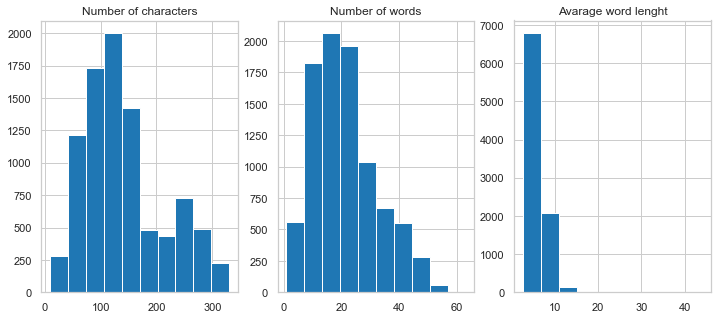

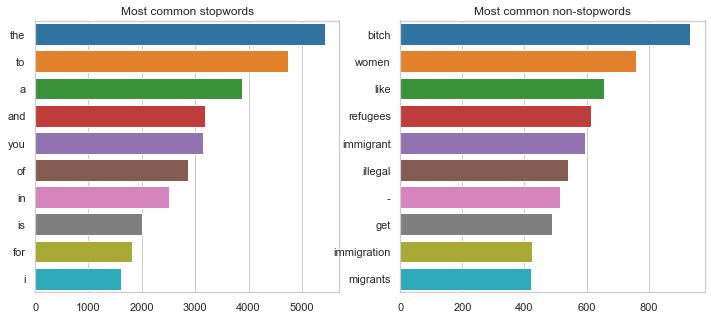

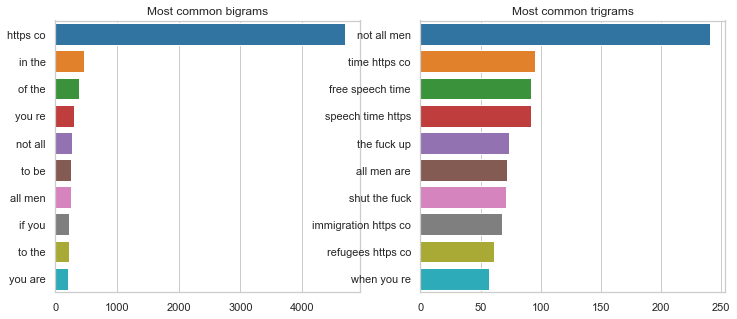

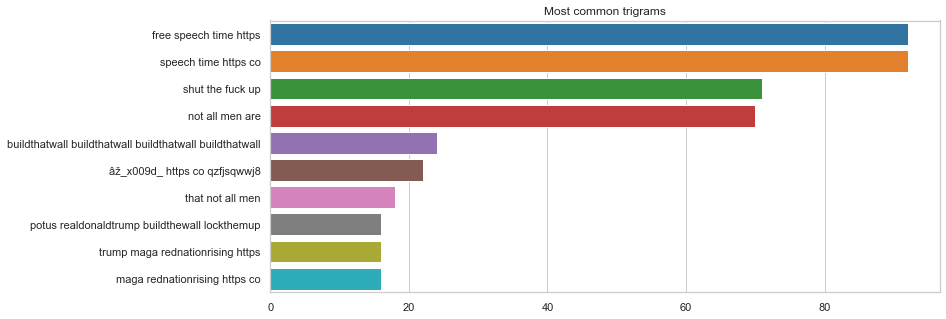



TRAIN with HS:

Distribution of features:
HS: 100.0%
HS -> TR: 35.448057097541636%
HS -> AG: 41.210679355009255%
HS -> TR & AG: 12.344699973565953%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.7869415807560137, 20)
Number of tweets that contain a mention: 0.4557229711868887
Most Common mentions:
                  Count   HS  HS -> TR  HS -> AG
Mention                                         
@realdonaldtrump    213  1.0  0.122066  0.586854
@potus               80  1.0  0.125000  0.562500
@isupport_israel     55  1.0  0.127273  0.436364
@anncoulter          31  1.0  0.741935  0.258065
@housegop            29  1.0  0.034483  0.655172
@senategop           23  1.0  0.043478  0.565217
@foxnews             21  1.0  0.333333  0.333333
@icegov              20  1.0  0.150000  0.650000
@mailonline          19  1.0  0.105263  0.368421
@speakerryan         18  1.0  0.000000  0.666667

Hashtags:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 1.13111287338

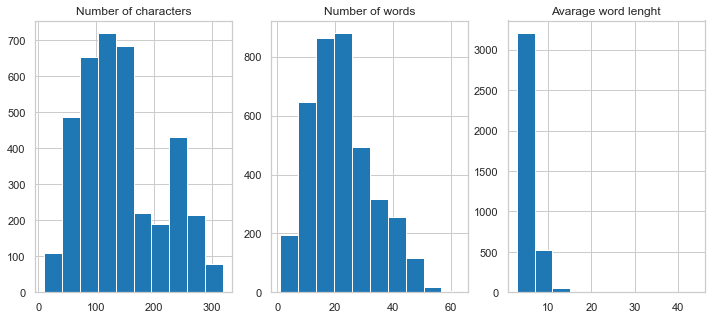

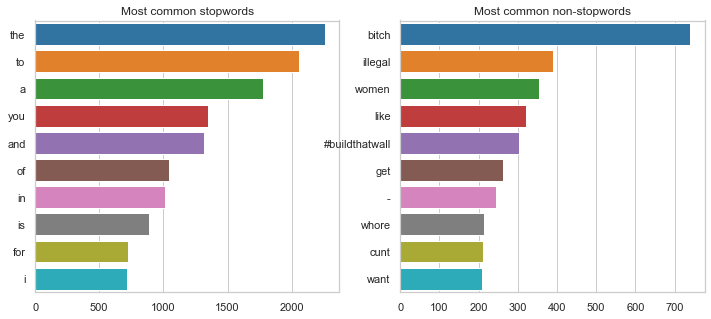

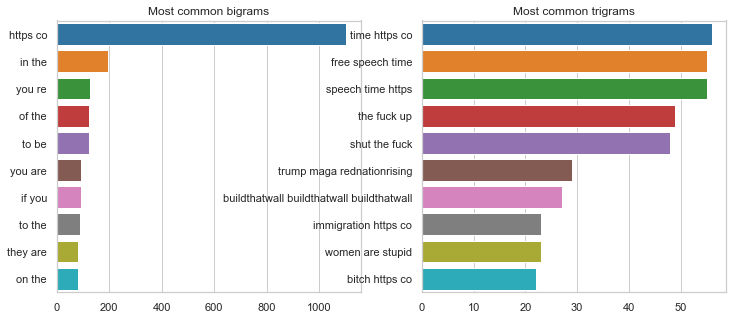

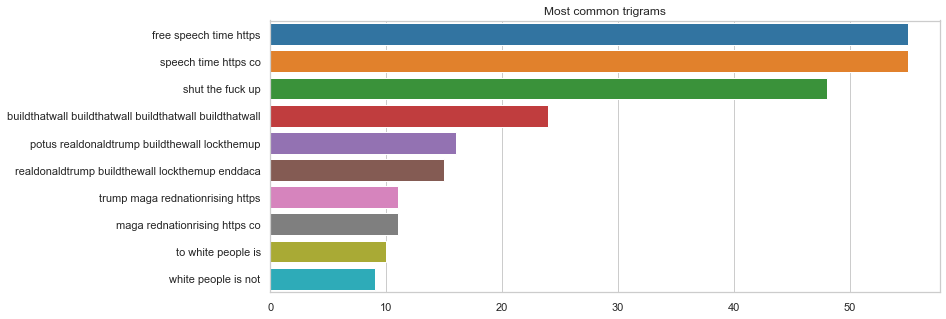



DEV:

Distribution of features:
HS: 42.7%
HS -> TR: 51.288056206088996%
HS -> AG: 47.7751756440281%
HS -> TR & AG: 25.526932084309134%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.922, 42)
Number of tweets that contain a mention: 0.504
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@anncoulter          47  0.680851  0.968750  0.218750
@realdonaldtrump     35  0.571429  0.150000  0.550000
@isupport_israel     13  0.461538  0.166667  0.500000
@potus               11  0.909091  0.000000  0.600000
@youtube              9  0.111111  0.000000  0.000000
@senkamalaharris      9  1.000000  1.000000  0.111111
@corybooker           9  0.555556  1.000000  0.000000
@donaldjtrumpjr       7  0.857143  0.833333  0.166667
@housegop             6  1.000000  0.000000  1.000000
@foxnews              5  0.800000  0.000000  0.250000

Hashtags:
Number of mentions per tweet (MIN, MEAN, MA

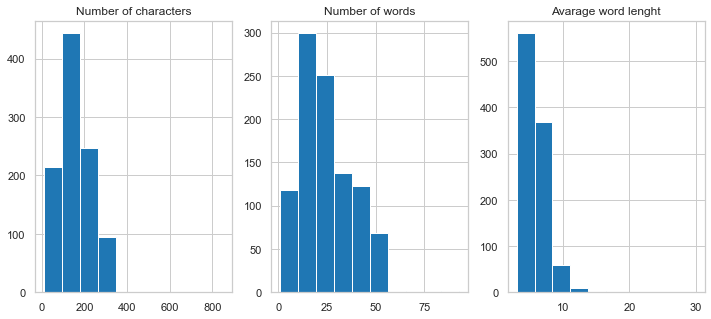

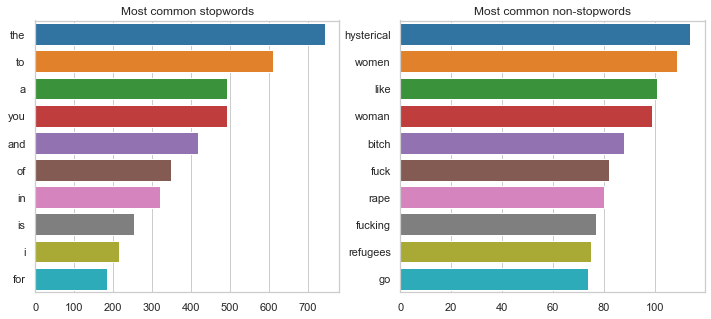

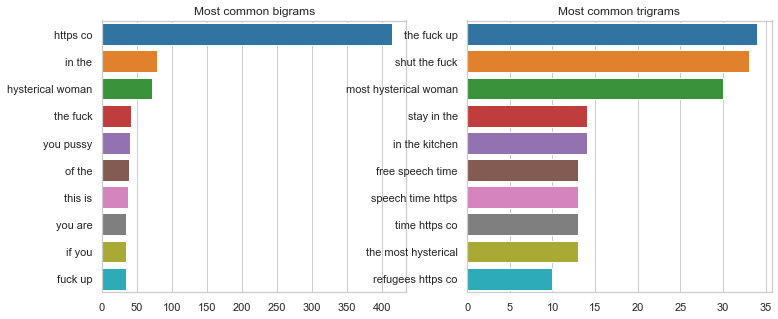

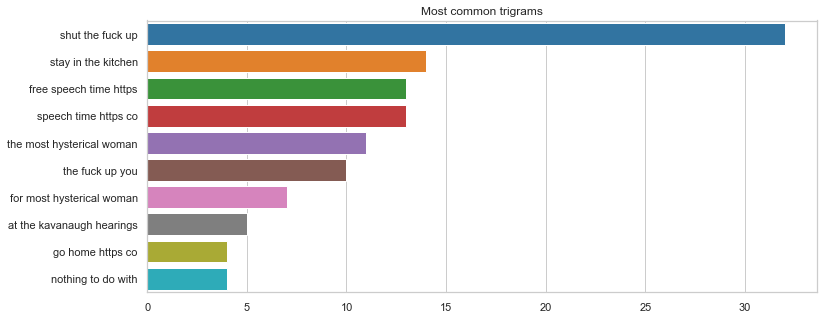



TEST:

Distribution of features:
HS: 42.0%
HS -> TR: 41.98412698412698%
HS -> AG: 47.142857142857146%
HS -> TR & AG: 14.523809523809524%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 1.0643333333333334, 40)
Number of tweets that contain a mention: 0.469
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@realdonaldtrump    233  0.304721  0.028169  0.690141
@potus               85  0.200000  0.000000  0.647059
@realjameswoods      41  0.073171  0.000000  0.333333
@foxnews             32  0.312500  0.000000  0.600000
@speakerryan         29  0.379310  0.090909  0.454545
@housegop            28  0.821429  0.043478  0.608696
@icegov              23  0.739130  0.000000  0.764706
@gop                 22  0.454545  0.000000  0.500000
@senategop           22  0.818182  0.000000  0.722222
@                    20  0.300000  0.333333  0.333333

Hashtags:
Number of mentions per tweet

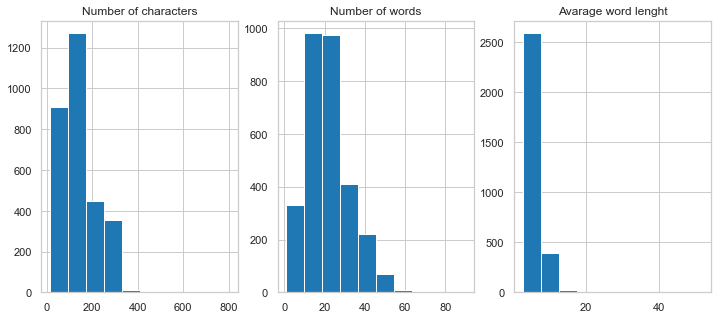

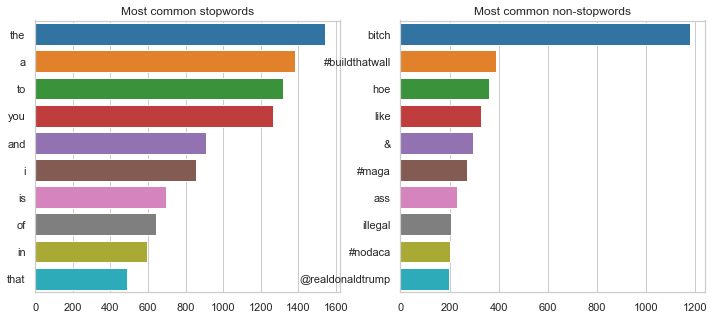

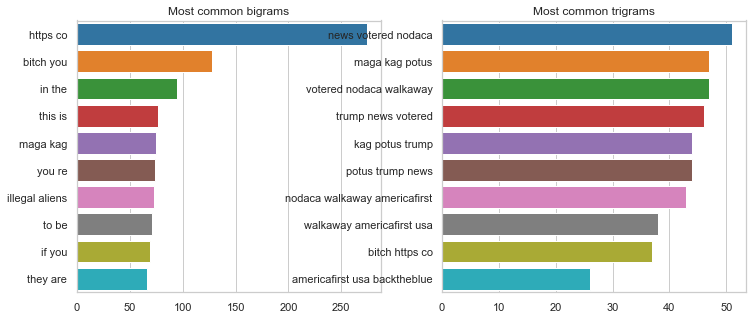

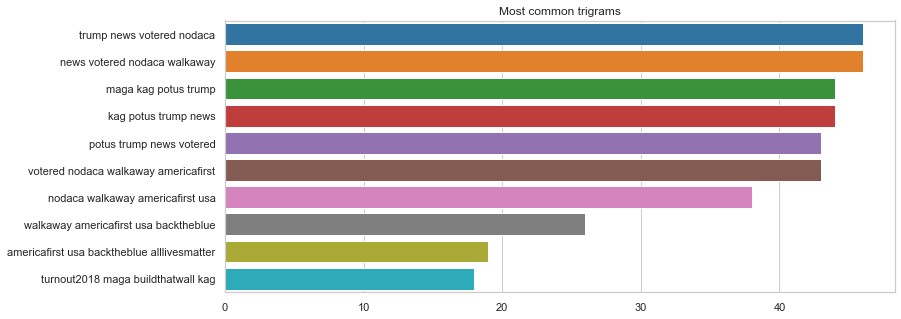

In [13]:
print("TRAIN:\n")
basic_statistics_plot(english_train)
print("\n\nTRAIN with HS:\n")
basic_statistics_plot(english_train, HS=True)
print("\n\nDEV:\n")
basic_statistics_plot(english_dev)
print("\n\nTEST:\n")
basic_statistics_plot(english_test)

# Preprocessing

TRY:

- Remove links
- Lowercase all characters
- Remove emojis
- Substitution of abbreviations
- Remove stopwords (?)
- Correct spelling mistakes (?)
- Remove numbers (or replace by word "number")
- Replace ”&” for "and"
- Remove punctuation
- Standardize blank spaces
- Normalize contractions
